<a href="https://colab.research.google.com/github/MichaelTay/w281-summer-2023-project/blob/main/VGG19_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive

mountdir = '/content/drive/'
drive.mount(mountdir, force_remount=True)

localdir = mountdir + 'MyDrive'
w281_dir = '/Berkeley/w281/Fruit-and-Vegetable-Classification/'
inputdir = localdir + w281_dir
vggdir = inputdir + 'modeling/vgg_data/'

Mounted at /content/drive/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os.path

from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_curve,
                             auc, RocCurveDisplay,
                             classification_report,
                             confusion_matrix,accuracy_score)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score, make_scorer, ConfusionMatrixDisplay
from sklearn.utils import shuffle

from hyperopt import tpe, atpe, rand, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
from hyperopt.early_stop import no_progress_loss

from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from tqdm import tqdm

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

data_dir = 'drive/MyDrive/Berkeley/w281/Fruit-and-Vegetable-Classification/modeling/pca_datasets/'

In [3]:
!ls drive/MyDrive/Berkeley/w281/Fruit-and-Vegetable-Classification/modeling/pca_datasets/

test_daisy_lum_sat_hue.csv	validation_daisy_lum_sat_hue.csv
training_daisy_lum_sat_hue.csv


In [4]:
import os
import cv2

# Create a list with the filepaths for training and testing
train_dir = Path(inputdir, './input/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path(inputdir, './input/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path(inputdir, './input/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

## Filter only selected class

In [5]:
# Fruits - banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango.
# Vegetables - Bell Pepper, Cauliflower, Chilli Pepper, Peas, Corn, Spinach, Turnip, Garlic, Ginger, Cabbage
Fruits = ['banana', 'apple', 'pear', 'grapes', 'orange', 'kiwi', 'watermelon', 'pomegranate', 'pineapple', 'mango']
Vegetables = ['bell pepper', 'cauliflower', 'chilli pepper', 'peas', 'corn', 'spinach', 'turnip', 'garlic', 'ginger', 'cabbage']

train_df = train_df[train_df['Label'].isin(Fruits + Vegetables)]
test_df = test_df[test_df['Label'].isin(Fruits + Vegetables)]
val_df = val_df[val_df['Label'].isin(Fruits + Vegetables)]

print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 1540

Number of different labels: 20

Labels: ['mango' 'spinach' 'pear' 'grapes' 'ginger' 'bell pepper' 'chilli pepper'
 'turnip' 'corn' 'garlic' 'banana' 'cabbage' 'peas' 'watermelon'
 'cauliflower' 'apple' 'kiwi' 'orange' 'pomegranate' 'pineapple']


## Image processing

In [7]:
RANDOM_SEED = 1234
IMG_DIM = 512

def image_processing(path):

    img = imread(path)
    resized_img = resize(img, (IMG_DIM, IMG_DIM), anti_aliasing=True).astype(np.float32)
    resized_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2BGR)
    return resized_img

#### Processing Train images

In [8]:
train_images = []
train_labels = []

for i,j in enumerate(train_df.iterrows()):
    print(f"Processing image #: {i}")
    filepath, label = j[1]['Filepath'], j[1]['Label']

    try:
        im = image_processing(filepath)
        train_images.append(im)
        train_labels.append(label)
    except Exception as e:
        print(f"There was an {e.__class__.__name__} error while trying to process an image... continuing")
        print(f"The error occurred at image #{i}, {filepath}")
        continue

train_images = np.array(train_images)
train_labels = np.array(train_labels)

Processing image #: 0
Processing image #: 1
Processing image #: 2
Processing image #: 3
Processing image #: 4
Processing image #: 5
Processing image #: 6
Processing image #: 7
Processing image #: 8
Processing image #: 9
Processing image #: 10
Processing image #: 11
Processing image #: 12
Processing image #: 13
Processing image #: 14
Processing image #: 15
Processing image #: 16
Processing image #: 17
Processing image #: 18
Processing image #: 19
Processing image #: 20
Processing image #: 21
Processing image #: 22
Processing image #: 23
Processing image #: 24
Processing image #: 25
Processing image #: 26
Processing image #: 27
Processing image #: 28
Processing image #: 29
Processing image #: 30
Processing image #: 31
Processing image #: 32
Processing image #: 33
Processing image #: 34
Processing image #: 35
Processing image #: 36
Processing image #: 37
Processing image #: 38
Processing image #: 39
Processing image #: 40
Processing image #: 41
Processing image #: 42
Processing image #: 4

#### Processing Validation images

In [9]:
validation_images = []
validation_labels = []

for i,j in enumerate(val_df.iterrows()):
    print(f"Processing image #: {i}")
    filepath, label = j[1]['Filepath'], j[1]['Label']

    try:
        im = image_processing(filepath)
        validation_images.append(im)
        validation_labels.append(label)
    except Exception as e:
        print(f"There was an {e.__class__.__name__} error while trying to process an image... continuing")
        print(f"The error occurred at image #{i}, {filepath}")
        continue

validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

Processing image #: 0
Processing image #: 1
Processing image #: 2
Processing image #: 3
Processing image #: 4
Processing image #: 5
Processing image #: 6
Processing image #: 7
Processing image #: 8
Processing image #: 9
Processing image #: 10
Processing image #: 11
Processing image #: 12
Processing image #: 13
Processing image #: 14
Processing image #: 15
Processing image #: 16
Processing image #: 17
Processing image #: 18
Processing image #: 19
Processing image #: 20
Processing image #: 21
Processing image #: 22
Processing image #: 23
Processing image #: 24
Processing image #: 25
Processing image #: 26
Processing image #: 27
Processing image #: 28
Processing image #: 29
Processing image #: 30
Processing image #: 31
Processing image #: 32
Processing image #: 33
Processing image #: 34
Processing image #: 35
Processing image #: 36
Processing image #: 37
Processing image #: 38
Processing image #: 39
Processing image #: 40
Processing image #: 41
Processing image #: 42
Processing image #: 4

#### Processing Test images

In [10]:
test_images = []
test_labels = []

for i,j in enumerate(test_df.iterrows()):
    print(f"Processing image #: {i}")
    filepath, label = j[1]['Filepath'], j[1]['Label']

    try:
        im = image_processing(filepath)
        test_images.append(im)
        test_labels.append(label)
    except Exception as e:
        print(f"There was an {e.__class__.__name__} error while trying to process an image... continuing")
        print(f"The error occurred at image #{i}, {filepath}")
        continue

test_images = np.array(test_images)
test_labels = np.array(test_labels)

Processing image #: 0
Processing image #: 1
Processing image #: 2
Processing image #: 3
Processing image #: 4
Processing image #: 5
Processing image #: 6
Processing image #: 7
Processing image #: 8
Processing image #: 9
Processing image #: 10
Processing image #: 11
Processing image #: 12
Processing image #: 13
Processing image #: 14
Processing image #: 15
Processing image #: 16
Processing image #: 17
Processing image #: 18
Processing image #: 19
Processing image #: 20
Processing image #: 21
Processing image #: 22
Processing image #: 23
Processing image #: 24
Processing image #: 25
Processing image #: 26
Processing image #: 27
Processing image #: 28
Processing image #: 29
Processing image #: 30
Processing image #: 31
Processing image #: 32
Processing image #: 33
Processing image #: 34
Processing image #: 35
Processing image #: 36
Processing image #: 37
Processing image #: 38
Processing image #: 39
Processing image #: 40
Processing image #: 41
Processing image #: 42
Processing image #: 4

In [11]:
train_label_encoder = LabelEncoder()
encoded_train_labels = train_label_encoder.fit_transform(train_labels)

validation_label_encoder = LabelEncoder()
encoded_validation_labels = validation_label_encoder.fit_transform(validation_labels)

test_label_encoder = LabelEncoder()
encoded_test_labels = test_label_encoder.fit_transform(test_labels)

## VGG model

In [12]:
VGG_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_DIM, IMG_DIM, 3))

for layer in VGG_model.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [13]:
VGG_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

## Modeling

##### Features: <br> VGG-19

##### Make VGG-19 training feature

In [14]:
extracted_train_features = VGG_model.predict(train_images)

49/49 [==============================] - 3047s 62s/step


In [16]:
X_train = extracted_train_features.reshape(extracted_train_features.shape[0], -1)

In [73]:
encoded_train_labels.shape

(1540,)

##### Make VGG-19 validation feature

In [22]:
extracted_validation_feature = VGG_model.predict(validation_images)

6/6 [==============================] - 369s 61s/step


In [23]:
X_val = extracted_validation_feature.reshape(extracted_validation_feature.shape[0], -1)

#### Make VGG-19 test feature

In [24]:
extracted_test_feature = VGG_model.predict(test_images)

6/6 [==============================] - 368s 61s/step


In [25]:
X_test = extracted_test_feature.reshape(extracted_test_feature.shape[0], -1)

### PCA

In [26]:
# Import required modules
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [90]:


def plotPCA(df, n_components=200):

  # Perform fit
  pca = PCA(n_components=n_components)
  pca_result = pca.fit_transform(df)

  PC_values = np.arange(pca.n_components_) + 1
  plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
  plt.bar(PC_values, np.cumsum(pca.explained_variance_ratio_), color ='maroon',
          width = 0.4)
  plt.ylim(0.0,1.05)

  plt.xlabel('Principal Component')
  plt.ylabel('Variance Explained')
  plt.show()

In [27]:
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(X_train)
scaled_x_val = scaler.transform(X_val)

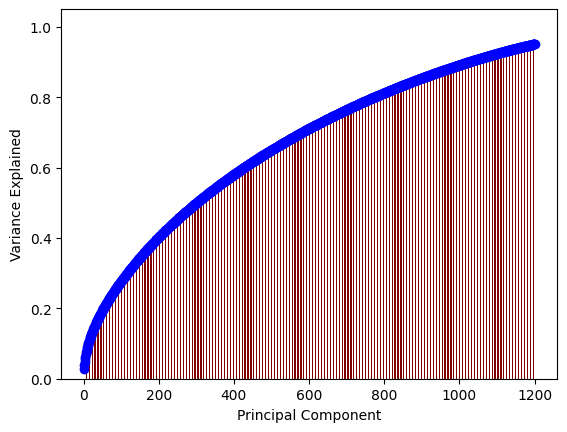

In [95]:
plotPCA(scaled_x_train, 1200)

In [28]:
pca = PCA(n_components=1200)
pca_x_train = pca.fit_transform(X_train)
pca_x_val = pca.transform(X_val)
pca_x_test = pca.transform(X_test)

In [32]:
# pd.concat([pd.DataFrame(pca_x_train),pd.DataFrame(encoded_train_labels)], axis=1).to_csv(vggdir+'vgg_train.csv')
# pd.concat([pd.DataFrame(pca_x_val),pd.DataFrame(encoded_validation_labels)], axis=1).to_csv(vggdir+'vgg_validation.csv')
# pd.concat([pd.DataFrame(pca_x_test),pd.DataFrame(encoded_test_labels)], axis=1).to_csv(vggdir+'vgg_test.csv')


##### Bayesian Parameter Search

In [112]:
# space = {'eta': hp.uniform('eta',0.001, 0.1),
#         "n_estimators":hp.choice("n_estimators",list(np.arange(100, 1000,200,dtype=int))),
#         "max_depth": hp.choice("max_depth", list(np.arange(1, 15,1,dtype=int))),
#         "subsample": hp.uniform('subsample', 0.3, 0.8),
#          "colsample_bytree": hp.uniform('colsample_bytree', 0.3, 0.8),
#          "gamma": hp.uniform('gamma', 0.0, 0.9),
#          "min_child_weight": hp.choice('min_child_weight', np.arange(1,8,2, dtype=int)),
#          "reg_alpha": hp.uniform("reg_alpha", 0.001, 1)
#         }

space = {'eta': hp.uniform('eta',0.001, 1.0),
        "n_estimators" : hp.choice("n_estimators", list(np.arange(100, 500, 100)))
        # "subsample": hp.uniform('subsample', 0.3, 0.8),
        #  "colsample_bytree": hp.uniform('colsample_bytree', 0.3, 0.8),
        #  "gamma": hp.uniform('gamma', 0.0, 0.9),
        #  "min_child_weight": hp.choice('min_child_weight', np.arange(1,8,2, dtype=int)),
        #  "reg_alpha": hp.uniform("reg_alpha", 0.001, 1)
        }

In [113]:
def optimize_xg(params):

    skf = StratifiedKFold(n_splits=3)
    clf = xgb.XGBClassifier(**params)
    cv_accuracy = cross_val_score(clf, pca_x_train, encoded_train_labels,
                         scoring=make_scorer(accuracy_score),
                                cv=skf,
                                n_jobs=-1).mean()
    best_score = np.mean(cv_accuracy)
    loss = 1 - best_score
    return {"loss":loss, "status":STATUS_OK}


In [114]:
RANDOM_SEED = 42
trials = Trials()

best = fmin(
    fn=optimize_xg,
    space=space,
    # algo=rand.suggest,
    # algo=atpe.suggest,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    early_stop_fn=no_progress_loss(5),
    rstate=np.random.default_rng(RANDOM_SEED)
)

print("Best: {}".format(best))

  9%|▉         | 9/100 [41:55<7:03:56, 279.52s/trial, best loss: 0.470784252748892]
Best: {'eta': 0.21300489987634189, 'n_estimators': 2}


#### XGBoost with Hyperopt params on Validation set

In [115]:
list(np.arange(100, 500, 100))

[100, 200, 300, 400]

In [33]:
params = {'eta':0.21300489987634189,
          'n_estimators': 300}

[0]	validation_0-mlogloss:2.12214	validation_1-mlogloss:1.94978
[1]	validation_0-mlogloss:1.61503	validation_1-mlogloss:1.42997
[2]	validation_0-mlogloss:1.26448	validation_1-mlogloss:1.11152
[3]	validation_0-mlogloss:1.01360	validation_1-mlogloss:0.88479
[4]	validation_0-mlogloss:0.82613	validation_1-mlogloss:0.72130
[5]	validation_0-mlogloss:0.67868	validation_1-mlogloss:0.59697
[6]	validation_0-mlogloss:0.56211	validation_1-mlogloss:0.50071
[7]	validation_0-mlogloss:0.47000	validation_1-mlogloss:0.42675
[8]	validation_0-mlogloss:0.39503	validation_1-mlogloss:0.36842
[9]	validation_0-mlogloss:0.33321	validation_1-mlogloss:0.31898
[10]	validation_0-mlogloss:0.28242	validation_1-mlogloss:0.28146
[11]	validation_0-mlogloss:0.24009	validation_1-mlogloss:0.24921
[12]	validation_0-mlogloss:0.20559	validation_1-mlogloss:0.22457
[13]	validation_0-mlogloss:0.17706	validation_1-mlogloss:0.20421
[14]	validation_0-mlogloss:0.15288	validation_1-mlogloss:0.18659
[15]	validation_0-mlogloss:0.13309	

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

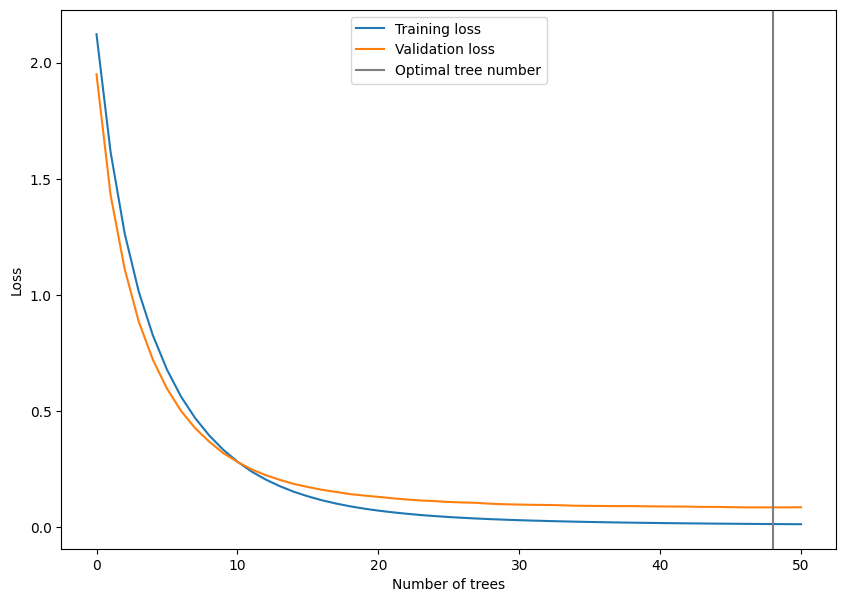

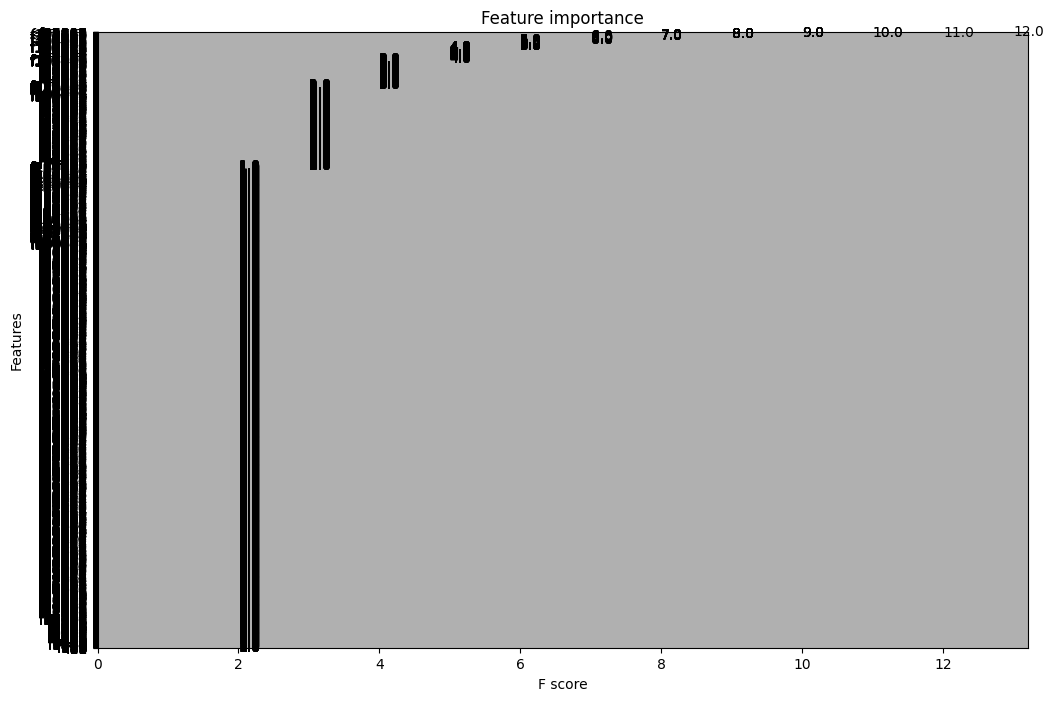

In [117]:

## use the wherevery XGboost early stops as n_estimator parameter in final model
xg1 = xgb.XGBClassifier(**params,
                        early_stopping_rounds=3,
                        n_jobs=-1)

xg1.fit(X_train, encoded_train_labels,
            eval_set=[(X_train, encoded_train_labels), (X_val, encoded_validation_labels)])

val_results = xg1.evals_result()
plt.figure(figsize=(10,7))
plt.plot(val_results["validation_0"]["mlogloss"], label="Training loss")
plt.plot(val_results["validation_1"]["mlogloss"], label="Validation loss")
plt.axvline(xg1.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(xg1,ax=ax)

In [119]:
xg1.best_ntree_limit

48

#### Predict on Validation Set

In [34]:
xg_val_clf = xgb.XGBClassifier(n_estimators=48,
                               eta=0.21300489987634189,
                               n_jobs=-1)

xg_val_clf.fit(pca_x_train, encoded_train_labels)

y_pred = xg_val_clf.predict(pca_x_val)

print(accuracy_score(encoded_validation_labels, y_pred))

0.983957219251337


In [35]:
print(classification_report(encoded_validation_labels
                            ,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        10
           7       0.91      1.00      0.95        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00         7
          13       0.91      1.00      0.95        10
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10
          17       1.00    

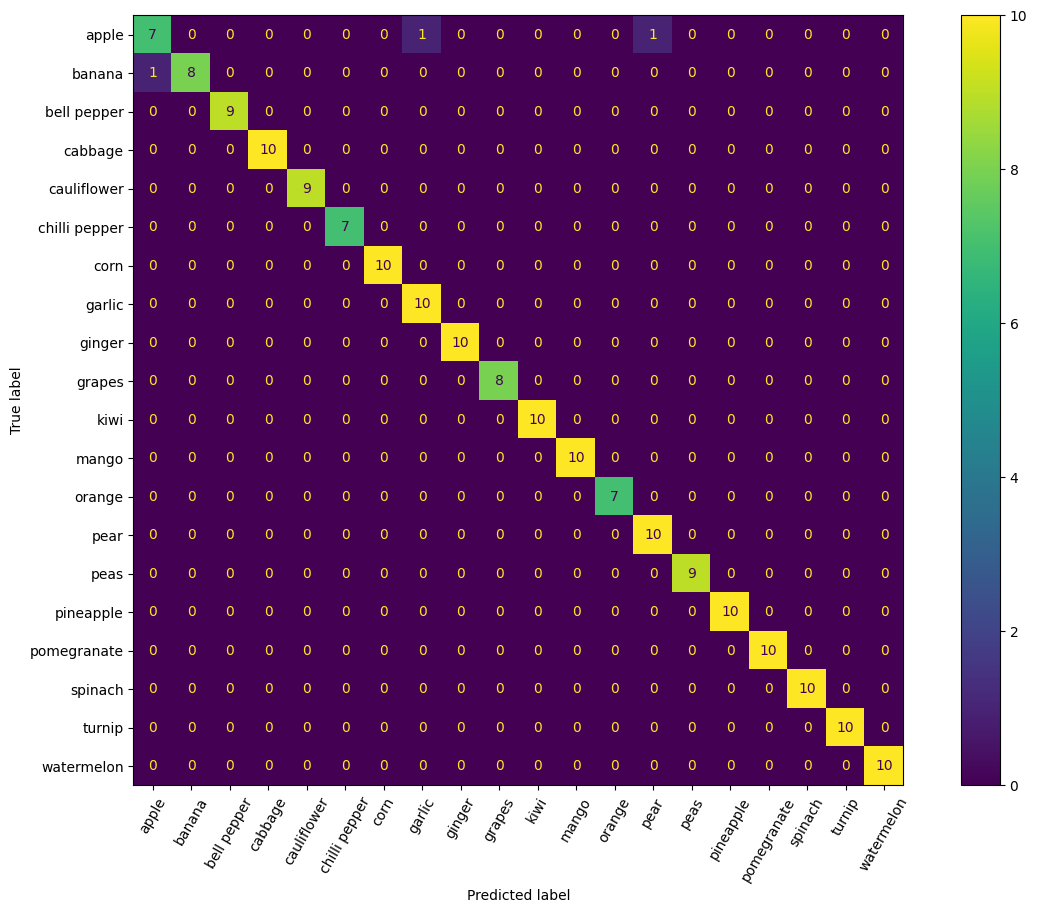

In [43]:
inverse_val_labels = validation_label_encoder.inverse_transform(encoded_validation_labels)
inverse_y_pred = validation_label_encoder.inverse_transform(y_pred)

fig, ax = plt.subplots(figsize=(15,10))
ConfusionMatrixDisplay.from_predictions(inverse_val_labels, inverse_y_pred, xticks_rotation=60, ax=ax);

#### Predict on Test Set

In [44]:
xg_test_clf = xgb.XGBClassifier(n_estimators=48,
                               eta=0.21300489987634189,
                               n_jobs=-1)

xg_test_clf.fit(pca_x_train, encoded_train_labels)

y_test_pred = xg_test_clf.predict(pca_x_test)

print(accuracy_score(encoded_test_labels, y_test_pred))

0.983957219251337


In [45]:
print(classification_report(encoded_test_labels,
                            y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        10
           7       0.91      1.00      0.95        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00         7
          13       0.91      1.00      0.95        10
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10
          17       1.00    

In [ ]:
inverse_test_labels = test_label_encoder.inverse_transform(encoded_test_labels)
inverse_y_test_pred = test_label_encoder.inverse_transform(y_test_pred)

In [47]:
print(classification_report(inverse_test_labels,
                            inverse_y_test_pred))

               precision    recall  f1-score   support

        apple       0.88      0.78      0.82         9
       banana       1.00      0.89      0.94         9
  bell pepper       1.00      1.00      1.00         9
      cabbage       1.00      1.00      1.00        10
  cauliflower       1.00      1.00      1.00         9
chilli pepper       1.00      1.00      1.00         7
         corn       1.00      1.00      1.00        10
       garlic       0.91      1.00      0.95        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         8
         kiwi       1.00      1.00      1.00        10
        mango       1.00      1.00      1.00        10
       orange       1.00      1.00      1.00         7
         pear       0.91      1.00      0.95        10
         peas       1.00      1.00      1.00         9
    pineapple       1.00      1.00      1.00        10
  pomegranate       1.00      1.00      1.00        10
      spi

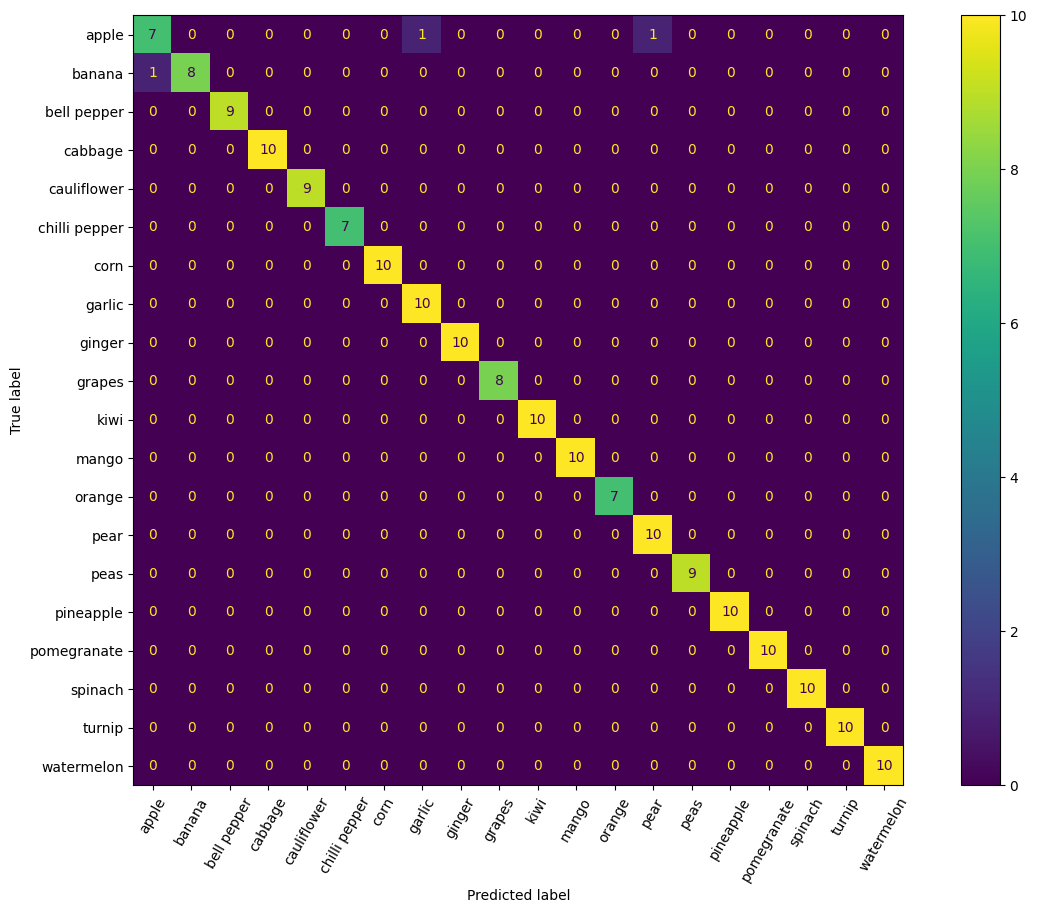

In [46]:
fig, ax = plt.subplots(figsize=(15,10))
ConfusionMatrixDisplay.from_predictions(inverse_test_labels, inverse_y_test_pred, xticks_rotation=60, ax=ax);